# Beam Shape Analysis - Cleaved Fibre, Full Radial Analysis

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

## Import all useful libraries / tools

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

from lvl4_functions import *

## Import Data

In [52]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-12/Data-Red-2/"

In [53]:
# Import data
distances, amplitudes = import_data(globalpath)

['DL_08.csv', 'DL_09.csv', 'DL_10.csv', 'DL_11.csv', 'DL_12.csv', 'DL_13.csv', 'DL_14.csv', 'DL_15.csv', 'DL_16.csv', 'DL_17.csv', 'DL_18.csv', 'DRR_08.csv', 'DRR_09.csv', 'DRR_10.csv', 'DRR_11.csv', 'DRR_12.csv', 'DRR_13.csv', 'DRR_14.csv', 'DRR_15.csv', 'DRR_16.csv', 'DRR_17.csv', 'DRR_18.csv', 'DR_08.csv', 'DR_09.csv', 'DR_10.csv', 'DR_11.csv', 'DR_12.csv', 'DR_13.csv', 'DR_14.csv', 'DR_15.csv', 'DR_16.csv', 'DR_17.csv', 'DR_18.csv', 'H_08.csv', 'H_09.csv', 'H_10.csv', 'H_11.csv', 'H_12.csv', 'H_13.csv', 'H_14.csv', 'H_15.csv', 'H_16.csv', 'H_17.csv', 'H_18.csv', 'V_08.csv', 'V_09.csv', 'V_10.csv', 'V_11.csv', 'V_12.csv', 'V_13.csv', 'V_14.csv', 'V_15.csv', 'V_16.csv', 'V_17.csv', 'V_18.csv']


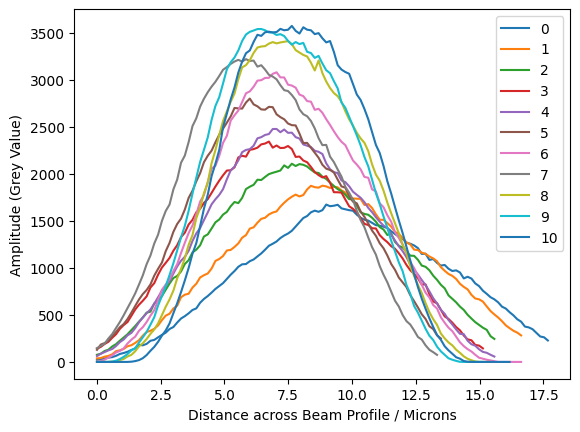

In [54]:
# Define how many data points we have. 'data size'
ds = 11

# Quick plot of raw data
for i in range(ds):
    plt.plot(distances[i+ds], amplitudes[i+ds], label = '{}'.format(i))

plt.legend()

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [55]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

## Errors - for above normalised Gaussians

In [56]:
''' Error on cross sectional distance'''
# Scale says ~4.3055 pixels / microns therefore 0.232 microns / pixel
# so lets set error as 0.2 microns

all_distances_errors = []

for i in range(len(all_distances)):
    all_distances_errors.append(np.ones(np.size(all_distances[i]))*0.2) # takes into account different sized data sets

''' Error on amplitude '''
# Grey value resolution = 1
# But 12 bit image = 2^12 = 4096 available 'colours'
# Say 10% accuracy

all_amps_errors = []

for i in range(len(all_amps)):
    err = 40.96 / np.max(amplitudes[i])
    all_amps_errors.append(np.ones(np.size(all_amps[i]))*err) # takes into account different sized data sets

Plot Normalised Gaussian Curves with Errors

In [57]:
# Plot of a far field 'Gaussian' - is this a TEM10 mode?
# plt.errorbar(all_distances[-1], all_amps[-1], xerr=all_distances_errors[-1],yerr=all_amps_errors[-1])

## Fit Data

[6.68992603 6.47103007 6.49610071 5.98088695 6.07882342 5.57365142
 5.46979139 5.37155521 5.20705831 5.10498451 5.10180587 8.13127433
 7.7436321  7.30075475 6.76221436 6.53341218 6.13565323 6.16170624
 5.86406614 5.69489879 5.60539078 5.47087722 7.91800856 7.57922109
 7.45735191 6.92160048 6.72994327 6.4372508  5.94666274 5.94488486
 5.74849651 5.65421272 5.65945099 6.42358569 6.17548856 6.15195474
 5.95354383 5.98824459 5.71593975 5.60691557 5.51076653 5.48013782
 5.34883383 5.22513864 6.92734126 6.71071967 6.79677303 5.94149874
 5.81305904 5.58005123 5.64099904 5.60882352 5.61437727 5.46474271
 5.49206934]
55
[0.03807554 0.03395322 0.03062676 0.02612765 0.02408135 0.02027262
 0.0189397  0.01751155 0.0160427  0.01501035 0.01433446 0.04550613
 0.0386075  0.03305419 0.02805936 0.0253956  0.02253188 0.01949515
 0.01827828 0.01614025 0.01517824 0.01453926 0.039578   0.03700671
 0.03092712 0.02745773 0.02375984 0.02141064 0.01959293 0.01813476
 0.01689946 0.01533502 0.01448031 0.03804079 0

Text(0.5, 1.0, 'Waist Size Trend - Errorbars too small to see')

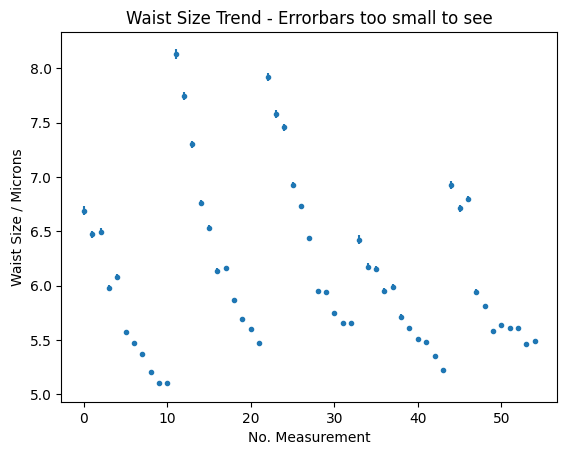

In [58]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),3))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),3))
chi_red_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),3))
initial_guesses[:,0] = 3
initial_guesses[:,1] = 6
initial_guesses[:,2] = 1
initial_guesses[1,1] = 10
initial_guesses[17,1] = 10
initial_guesses[18,1] = 10
# initial_guesses[6,0] = 15
# initial_guesses[14:,0] = 40
# initial_guesses[14:,1] = 50
# initial_guesses[0,0] = 0.2

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_red_array[i] = fit_labs(all_distances[i],all_amps[i], all_amps_errors[i], Gauss, initial_guesses[i])
    y_fits.append(singlefit)

waists = params_[:,0]
waists_errs = params_errs_[:,0]
print(waists)
print(len(waists))
print(waists_errs)

# Plot waist trend 
plt.errorbar(np.arange(len(all_distances)),waists, yerr = waists_errs, linestyle = '', marker = 'o', ms = 3)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')
plt.title('Waist Size Trend - Errorbars too small to see')

#print(waists, waists_errs)

Text(0, 0.5, 'Normalised Amplitude')

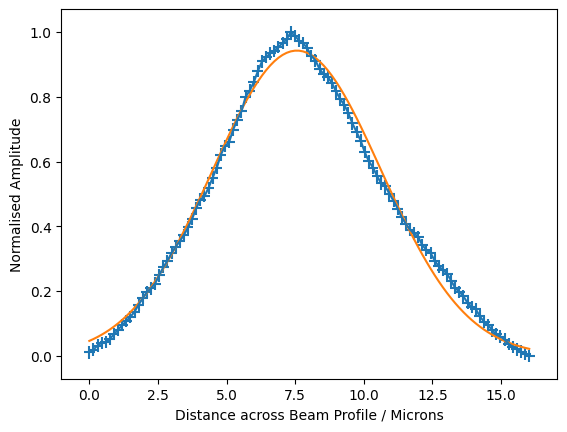

In [59]:
t = 35
plt.errorbar(all_distances[t], all_amps[t], xerr=all_distances_errors[t],yerr=all_amps_errors[t])
plt.plot(all_distances[t],y_fits[t])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

In [60]:
''' Split waist fits into vertical and horizontal measurements and take average'''

dl_waists = waists[0:ds]
drr_waists = waists[ds:2*ds]
dr_waists = waists[2*ds:3*ds]
h_waists = waists[3*ds:4*ds]
v_waists = waists[4*ds:]

dl_waists_errs = waists_errs[0:ds]
drr_waists_errs = waists_errs[ds:2*ds]
dr_waists_errs = waists_errs[2*ds:3*ds]
h_waists_errs = waists_errs[3*ds:4*ds]
v_waists_errs = waists_errs[4*ds:]

waists_array = np.array([dl_waists,drr_waists, dr_waists, h_waists,v_waists]) 
mean_waists = np.mean(waists_array, axis = 0)
std_waists = np.std(np.array(waists_array), axis = 0) / np.sqrt(np.shape(waists_array)[0])
print(mean_waists, std_waists)

[7.21802717 6.9360183  6.84058703 6.31194887 6.2286965  5.88850929
 5.765215   5.66001925 5.54899374 5.43563291 5.38986841] [0.30453379 0.27650164 0.21789522 0.19490547 0.15454883 0.15313517
 0.11276383 0.09610253 0.08649292 0.08816001 0.08939757]


## Calculating Z values and Plotting Waist size against Z

In [61]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-12/Data-Red-2/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.abs(np.array(df_lengths['zs']))

# Take error as confocal z stack resolution ie 0.1
lengths_errs = np.ones(len(lengths))*0.1

In [62]:
print(lengths)

[41.  36.9 32.8 28.7 24.6 20.5 16.4 12.3  8.2  4.1  0. ]


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [63]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.635
wavelength_err = 0.005 # according to online spec (THORLABS CPS405)

Angle of elevation

<ErrorbarContainer object of 3 artists>

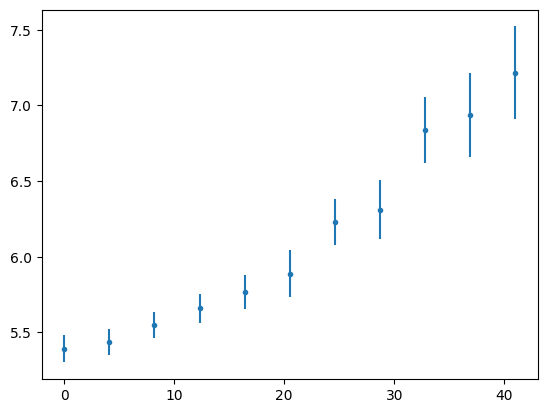

In [64]:
# online protractor at https://www.ginifab.com/feeds/angle_measurement/ 
# NB: see image 'C:\Users\abiga\OneDrive - Durham University\1. Fourth Year\1. Project\1. Data Analysis\Christmas Report\Cleaved-2\Cleaved - fibre- pics\cleaved_elev_angle'

# A plot of waists vs z
plt.errorbar(lengths, mean_waists, yerr = std_waists, linestyle = '', marker = 'o', ms = 3)


In [65]:
waist_fit, params, params_errs, chisqu_WvsZ = fit_labs(lengths, mean_waists, std_waists, WvsZ, np.array([5,1,2]))
w0, z0,RR= params
w0_err, z0_err,RR_err = params_errs

waist_fitdr, paramsdr, params_errsdr, chisqu_WvsZdr = fit_labs(lengths, dr_waists, std_waists, WvsZ, np.array([5,1,2]))
w0dr, z0dr,RRdr= paramsdr
w0_errdr, z0_errdr,RR_errdr = params_errsdr

The minimum waist is 5.39206454941607 pm 0.1004403104932895
The distance from the smallest z measurement to the minimum waist is -2.5277232556323117 pm 5.798098002137108
The Rayleigh Range is 48.368263640229195 pm 6.82572166307286.
The reduced chi squared value of this fit is 0.18341588636256143


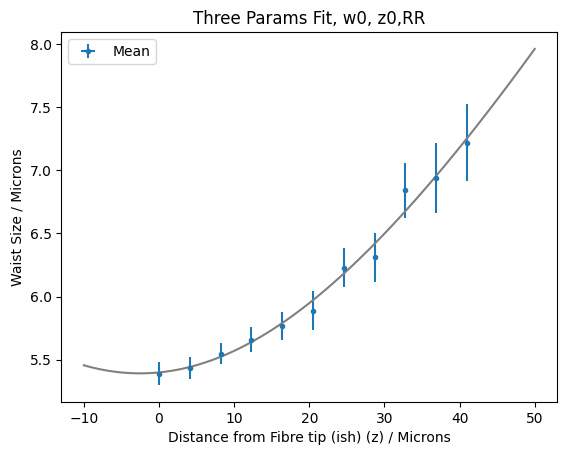

In [66]:
# Plot waists vs Z:
plt.errorbar(lengths, mean_waists, xerr = lengths_errs, yerr = std_waists, linestyle = '', marker = 'o', ms = 3, label = 'Mean')
plt.plot(np.linspace(-10,50,100), WvsZ(np.linspace(-10,50,100), w0, z0,RR), color = 'grey')

# plt.errorbar(lengths, h_waists, yerr = h_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Horizontal')
# plt.errorbar(lengths, dl_waists, yerr = dl_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'L Diagonal')
# plt.errorbar(lengths, dr_waists, yerr = dr_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'R Diagonal')
# plt.errorbar(lengths, v_waists, yerr = v_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Vertical')

plt.xlabel('Distance from Fibre tip (ish) (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Three Params Fit, w0, z0,RR')
plt.legend()

print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the smallest z measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR,RR_err))
print('The reduced chi squared value of this fit is {}'.format(chisqu_WvsZ))

In [67]:
print('The wavelength check in nanometres is {} nm'.format(wavelength_check(w0,RR)))
print('This is approx. {}x the actual wavelength'.format( wavelength_check(w0,RR) / (wavelength*10**3)))

print('The wavelength check in nanometres is {} nm'.format(wavelength_check(w0dr,RRdr)))
print('This is approx. {}x the actual wavelength'.format( wavelength_check(w0dr,RRdr) / (wavelength*10**3)))

The wavelength check in nanometres is 1888.424128542436 nm
This is approx. 2.973896265421159x the actual wavelength
The wavelength check in nanometres is 2515.456652891173 nm
This is approx. 3.961349059671138x the actual wavelength


Saving the important info in an array like:
x values
x errs
y values
y errs
residuals 

Second array:
w0, w0err
z0,z0_err
RR, RRerr
z_end, z_end_err

In [68]:
# np.save('graph_cleaved.npy', np.array([zs_0, zs_0_err, waists_comp, waists_comp_err, wz_res]))
# np.save('params_cleaved.npy', np.array([w0,w0_err,z0, z0_err, RR, RR_err, z_end, z_end_err]))

## Comparison to Experiment - Ray Optics Model

Find k0 and define constants 

In [69]:
# Defining Parameters of set-up
# info about fibre from 35m cable:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

#wavelength = 1.064 
# if want blue V number

NA = 0.14 # numerical aperture 
NA_err = 0.01

k0 = find_k(wavelength)
k0_err = np.abs(find_k(wavelength+wavelength_err) - k0)
print(k0, k0_err)

a = 9.2e-6 / 2 # core radius, in metres 
a_err = 0.1e-6 / 2 

9894780.011306435 77302.96883833222


Find V_no and its error

In [70]:
V_no = V_number(NA, k0, a)

EC_NA = np.abs(V_number(NA+NA_err, k0, a) - V_no)
EC_k0 = np.abs(V_number(NA, k0+k0_err, a)- V_no)
EC_a = np.abs(V_number(NA, k0, a+a_err) - V_no)

V_no_err = np.sqrt(EC_NA**2 + EC_k0**2 + EC_a**2)

In [71]:
print('The predicted V no is {} pm {}'.format(V_no, V_no_err))

The predicted V no is 6.3722383272813445 pm 0.4630834719257708


Using the Marcuse relation to compute theoretical minimum waist from V number and core radius

In [72]:
w0_theory = marcuse(V_no,a)

# error on w0
cont_V_no = np.abs(marcuse(V_no+V_no_err,a) - w0_theory)
cont_a = np.abs(marcuse(V_no,a+a_err) - w0_theory)

w0_theory_err = np.sqrt(cont_V_no**2 + cont_a**2)

In [73]:
print('The predicted minimum waist using the ray optics model is {} pm {} microns'.format(w0_theory,w0_theory_err))

The predicted minimum waist using the ray optics model is 3.4531825367426907 pm 0.05961222727460484 microns


## Report Plot - Did the Fibre taper as expected?

In [74]:
# Import Data from measure function 

measure_data_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Fibre2-30-11/measure_fn.xlsx'

measure_df = pd.read_excel(measure_data_path)

[127.59999847 127.49999619 128.00000381 ... 127.40000153 128.40000153
 127.40000153]


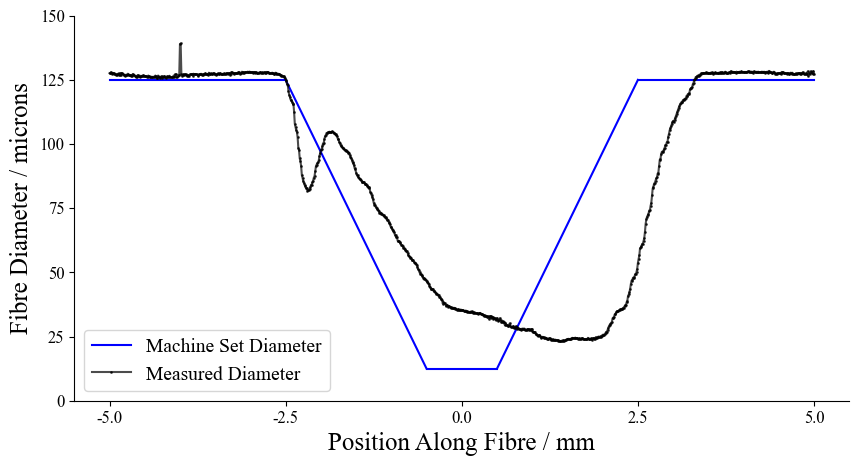

In [75]:
# Convert to Array 
diameter = np.array(measure_df['diam_x'])*10**3 # microns
position = np.array(measure_df['position']) - 5

# Theoretical Trend
theo_position = np.arange(-5,5.1,0.1)         
print(diameter) 

# Define Lines

def pos(x):
    return 56.25*x -15.625

def neg(x):
    return -56.25*x -15.625

def const(x):
    return np.ones(x.size)*12.5

neg_bit = np.linspace(-2.5,-0.5,100)
pos_bit = np.linspace(0.5,2.5,100)
const_bit = np.linspace(-0.5,0.5,100)

fig0, ax = plt.subplots(figsize = (10,5))

ax.errorbar(position, diameter, color = 'k', alpha = 0.7, linestyle = '-', marker = 'o', ms = 1, label = 'Measured Diameter')
ax.plot(neg_bit, neg(neg_bit), color = 'blue')
ax.plot(pos_bit, pos(pos_bit), color = 'blue')
ax.plot(const_bit, const(const_bit), color = 'blue')
ax.plot(np.linspace(-5,-2.5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue')
ax.plot(np.linspace(2.5,5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue', label = 'Machine Set Diameter')
ax.legend(prop = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=14))

ax.set_xlabel('Position Along Fibre / mm', font = 'Times New Roman', fontsize = 18)
ax.set_ylabel('Fibre Diameter / microns', font = 'Times New Roman', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(ticks = np.arange(0,152,25), labels = np.round_(np.arange(0,152,25), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)
ax.set_xticks(ticks = np.arange(-5,6,2.5), labels = np.arange(-5,6,2.5), fontfamily = 'Times New Roman', fontsize = 12)